# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

Клонируем репозиторий 

In [8]:
!git clone -b develop https://github.com/RadyshAlex/cvr_course.git

Cloning into 'cvr_course'...
remote: Enumerating objects: 517, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 517 (delta 8), reused 18 (delta 6), pack-reused 491
Receiving objects: 100% (517/517), 60.37 MiB | 35.65 MiB/s, done.
Resolving deltas: 100% (115/115), done.


Переходим в нужный каталог


In [10]:
%cd cvr_course/



/root/cvr_course


Импортируем необходимые библиотеки

In [13]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
import glob

Функции нахождения контура и растояния

In [56]:
def find_contour (img, low_th, high_th):
    
    
    mask = cv2.inRange (img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #cnt = contours [-1]

    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            cnt = contours[i]
            max_area = area

    approx = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)

    return approx

In [57]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    length = cv2.arcLength (contour, True)
    
    print (contour)

    distance = 180.0 * 364 / length
    
    return distance

Выводим изображения и найденные растояния от камеры до листа

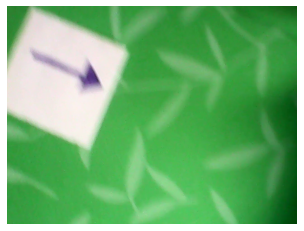

[[[257 102]]

 [[178 310]]

 [[  0 225]]

 [[ 59  18]]]
77.07543760345204


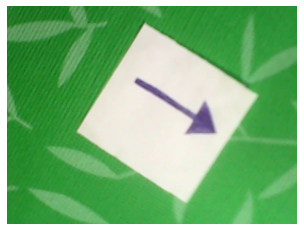

[[[547 196]]

 [[394 430]]

 [[158 277]]

 [[303  42]]]
58.213898179172


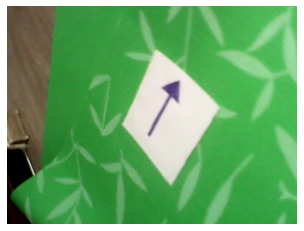

[[[465 222]]

 [[363 383]]

 [[256 261]]

 [[328 100]]]
91.934760625742


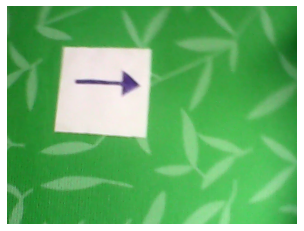

[[[315  99]]

 [[305 287]]

 [[108 273]]

 [[130  92]]]
86.98571825076148


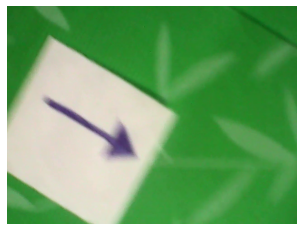

[[[325 244]]

 [[228 479]]

 [[  8 335]]

 [[164 118]]]
66.25763790351805


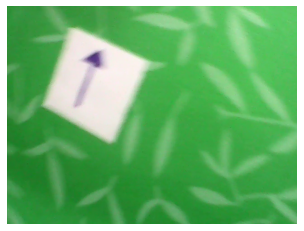

[[[307 122]]

 [[227 294]]

 [[ 90 213]]

 [[148  54]]]
94.81533612993083


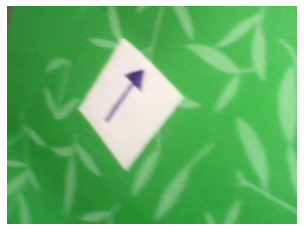

[[[386 200]]

 [[262 353]]

 [[164 229]]

 [[254  74]]]
91.4181030090751


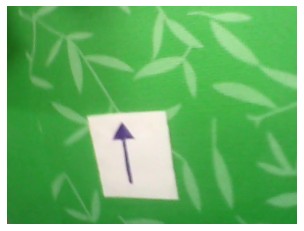

[[[373 423]]

 [[219 417]]

 [[180 246]]

 [[348 234]]]
95.15204916054759


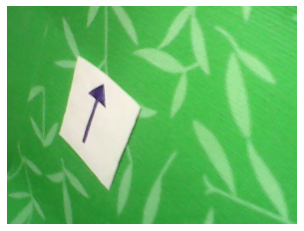

[[[159 113]]

 [[291 221]]

 [[215 393]]

 [[121 285]]]
96.64850710230294


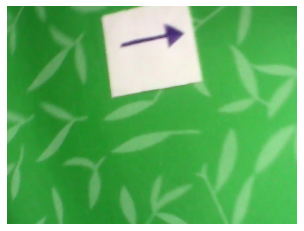

[[[427 162]]

 [[236 197]]

 [[216  28]]

 [[395   0]]]
92.1951292094964


In [58]:

images = glob.glob('/root/cvr_course/data/imgs/arrow/*.png')
for file in images:
  img = cv2.imread(file)

  img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
  plt.imshow (img_rgb)
  
  plt.axis ('off')
  plt.show ()
  dist = find_distance (img_rgb)
  print (dist)

Приведение изображения листка к "виду сверху"

In [88]:
def order_points(pts):

    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    if (np.argmax(s) > np.argmin(s)):
      pts = np.delete(pts, np.argmax(s), 0)
      pts = np.delete(pts, np.argmin(s), 0)
    else:
      pts = np.delete(pts, np.argmin(s), 0)
      pts = np.delete(pts, np.argmax(s), 0)

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [89]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped



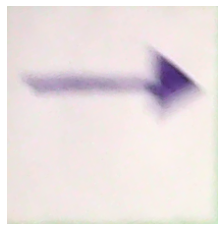

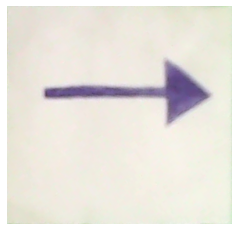

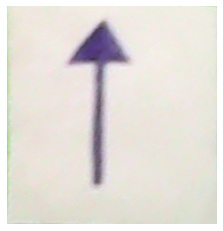

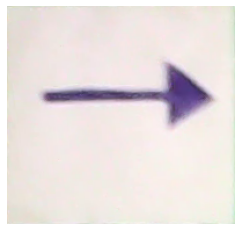

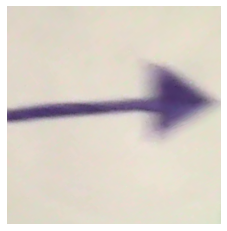

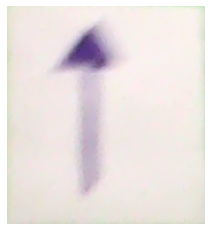

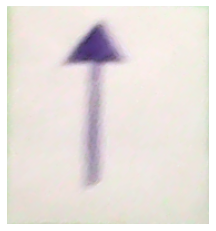

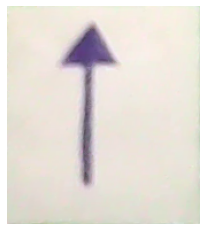

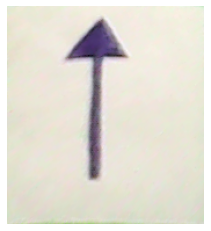

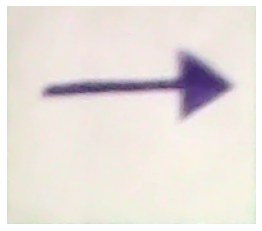

In [90]:
low_th  = (200, 200, 200)
high_th = (255, 255, 255)
for file in images:
  img = cv2.imread(file)
  img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
  warped = four_point_transform (img_rgb, np.asarray (find_contour (img_rgb, low_th, high_th)) [:, 0, :])

  plt.imshow (warped)
  plt.axis ('off')
  plt.show ()